In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
import scipy.stats as sps

### 0. Подготовим данные

#### 0.1 Выгружаем MNIST

In [2]:
%%time
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

Wall time: 37.3 s


In [3]:
type(mnist) #тип данных -- sklearn.utils.Bunch, надо распаковать

sklearn.utils.Bunch

In [4]:
type(mnist.data), type(mnist.categories), type(mnist.feature_names), type(mnist.target) #что и как лежит в полях

(pandas.core.frame.DataFrame, NoneType, list, pandas.core.series.Series)

In [5]:
mnist.data.shape, mnist.target.shape #имеем 70k размеченных изображений (28x28 пикселей)

((70000, 784), (70000,))

#### 0.2 Отрисуем изображения из датасета:

In [6]:
mnist.data.loc[0].unique() # яркость задана байтом от 0 до 255

array([  0.,   3.,  18., 126., 136., 175.,  26., 166., 255., 247., 127.,
        30.,  36.,  94., 154., 170., 253., 225., 172., 242., 195.,  64.,
        49., 238., 251.,  93.,  82.,  56.,  39., 219., 198., 182., 241.,
        80., 156., 107., 205.,  11.,  43.,  14.,   1.,  90., 139., 190.,
         2.,  70.,  35., 160., 108.,  81., 240., 119.,  25.,  45., 186.,
       150.,  27.,  16., 252., 187., 249.,  46., 130., 183., 207., 148.,
       229., 250.,  24., 114., 221., 201.,  78.,  23.,  66., 213., 171.,
         9.,  55., 226., 244., 133., 212., 135., 132.])

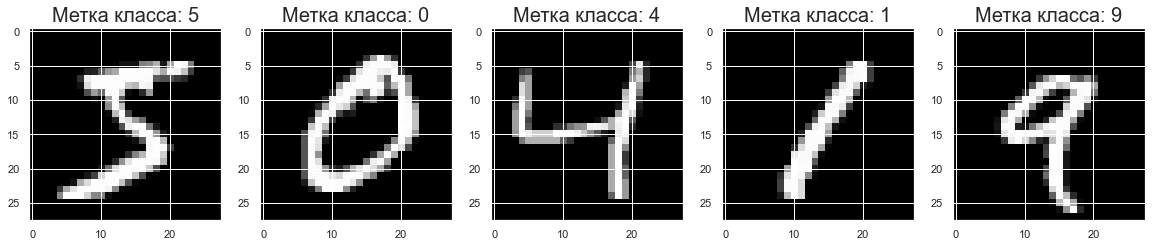

In [7]:
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.reshape(np.array(mnist.data.loc[i]), (28,28)), cmap=plt.cm.gray)
    plt.title(f'Метка класса: {mnist.target.loc[i]}', fontsize = 20)

#### 0.3 Побьём на трейн, (валидацию) и тест:

In [8]:
rn = pd.Series(sps.randint.rvs(1, 101, size = len(mnist.data), random_state = 42))

In [9]:
print(max(rn), min(rn), len(rn))

100 1 70000


In [10]:
#бьём на трейн/тест в соотношении 70/30
X = mnist.data
y = mnist.target
train_mask, val_mask, test_mask = (rn <= 60), ((rn > 60) & (rn <= 70)), (rn > 70)
X_train, y_train, X_test, y_test, X_val, y_val = X[train_mask], y[train_mask], X[test_mask], y[test_mask], X[val_mask], y[val_mask]

#### 0.4 Смотрим, что у нас с балансом классов:

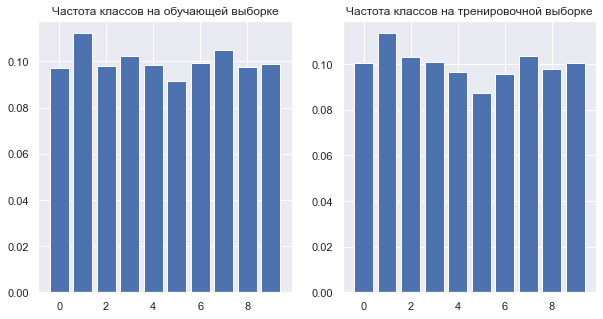

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tmp = pd.DataFrame({'class':y_train.astype(int), 'cnt':y_train})
tmp2 = tmp.groupby('class').agg({'class':'max','cnt':'count'})
plt.bar(tmp2['class'], tmp2['cnt']/len(tmp) )
plt.title('Частота классов на обучающей выборке');

plt.subplot(1,2,2)
tmp3 = pd.DataFrame({'class':y_test.astype(int), 'cnt':y_test})
tmp4 = tmp3.groupby('class').agg({'class':'max','cnt':'count'})
plt.bar(tmp4['class'], tmp4['cnt']/len(tmp3) )
plt.title('Частота классов на тренировочной выборке');

### 1. Учим логрег

#### 1.1 Базовый классификатор:

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(fit_intercept=True, # обучаемся со свободным членом
                        multi_class='multinomial', # мультиномиальный логрег, минимизирует кросс-энтропию
                        max_iter = 1000)

In [14]:
clf.fit(X_train, y_train) #учим

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [15]:
# import pickle
# with open('my_classifier.pkl', 'rb') as f:
#     sample_clf = pickle.load(f)

In [16]:
clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [17]:
clf.coef_.shape

(10, 784)

#### 1.2 Визуализация коэффициентов, которые выучила модель

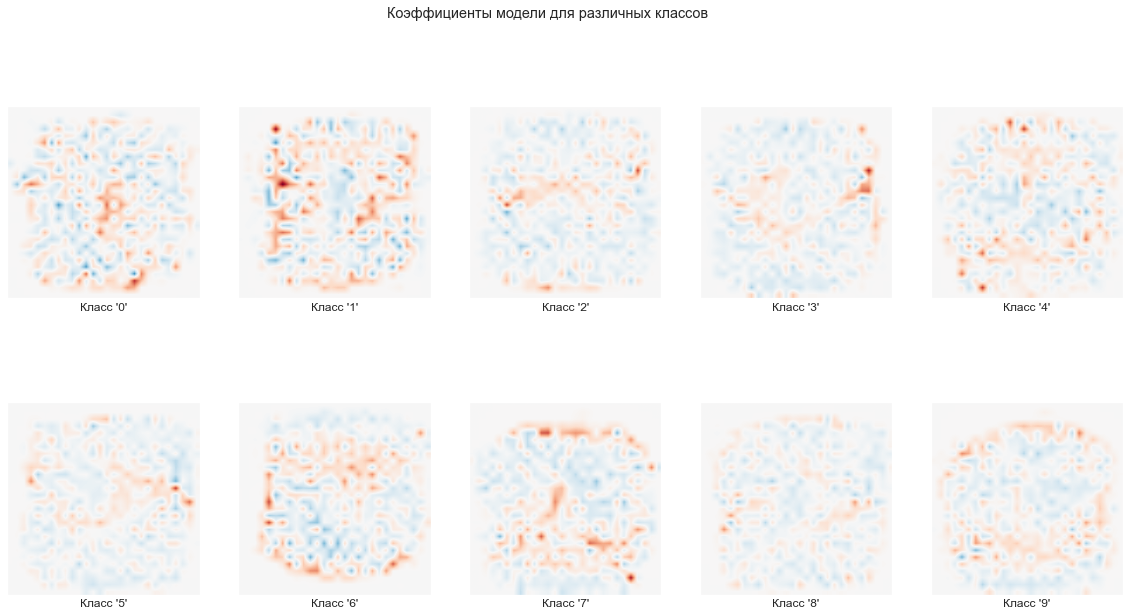

In [18]:
coef = clf.coef_.copy()
scale = np.abs(coef).max()
plt.figure(figsize=(20,10))

for i in range(10): # 0-9
    coef_plot = plt.subplot(2, 5, i + 1) # 2x5 plot

    coef_plot.imshow(coef[i].reshape(28,28), 
                     cmap=plt.cm.RdBu,
                     vmin=-scale, vmax=scale,
                    interpolation='bilinear')
    
    coef_plot.set_xticks(()); coef_plot.set_yticks(()) # remove ticks
    coef_plot.set_xlabel(f"Класс '{i}'")

plt.suptitle('Коэффициенты модели для различных классов');

### 2. Метрики обученной модели

#### 2.1 Accuracy

In [19]:
print(*clf.predict(X_test[0:9]))
print(*list(y_test[0:9]))

0 1 1 3 1 4 3 5 8
0 1 1 3 1 4 3 5 8


In [20]:
clf.score(X_train, y_train) # accuracy на обучающей выборке

0.9507032215147772

In [21]:
score_test = clf.score(X_test, y_test) # accuracy на тестовой выборке
print(f'Accuracy на тестовой выборке составила {round(score_test, 3)}')

Accuracy на тестовой выборке составила 0.913


#### 2.2 Confusion matrix

In [22]:
from sklearn import metrics

predictions = clf.predict(X_test)

cm = metrics.confusion_matrix(y_true=y_test, 
                         y_pred = predictions, 
                        labels = clf.classes_)

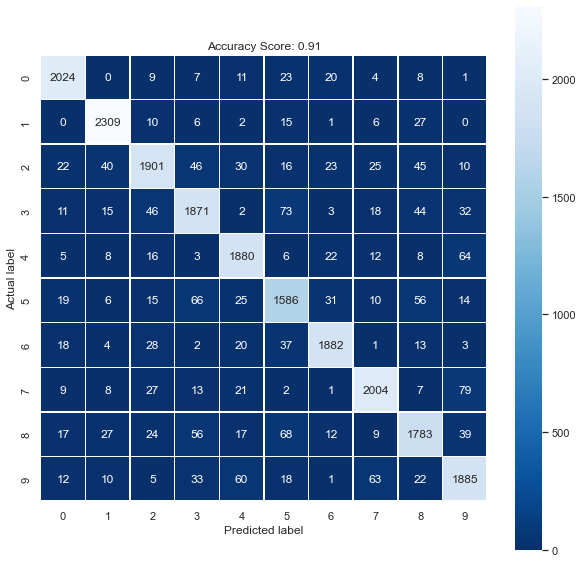

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(round(score_test, 2))
plt.title(all_sample_title);

#### Неверно предсказанные классификатором цифры:

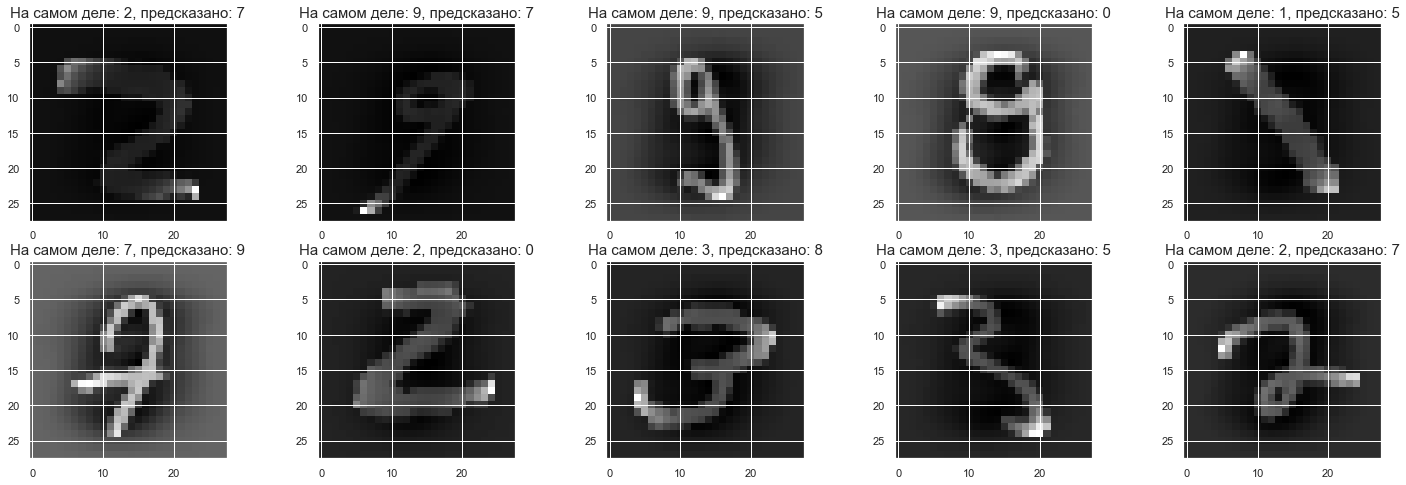

In [24]:
plot_ = list(X_test[y_test != predictions])
real_ = list(y_test[y_test != predictions])
predicted = list(predictions[y_test != predictions])

plt.figure(figsize=(25,8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(plot_[i], (28,28)), cmap=plt.cm.gray)
    plt.title(f'На самом деле: {real_[i]}, предсказано: {predicted[i]}', fontsize = 15)

#### 2.3 macro auc

In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
y_score = clf.predict_proba(X_test)

In [37]:
round(roc_auc_score(y_test, y_score, average='macro', multi_class = 'ovr'), 4)

0.9901

### 3. OvR Logistic Regression

#### 3.1 Учим

In [28]:
clf_ovr = LogisticRegression(fit_intercept=True, # обучаемся со свободным членом
                        multi_class='ovr', # учим просто 10 логрегов по схеме "один против остальных"
                        max_iter = 1000)

In [29]:
clf_ovr.fit(X_train, y_train) #учим

LogisticRegression(max_iter=1000, multi_class='ovr')

#### 3.2 Смотрим на визуализацию коэффициентов

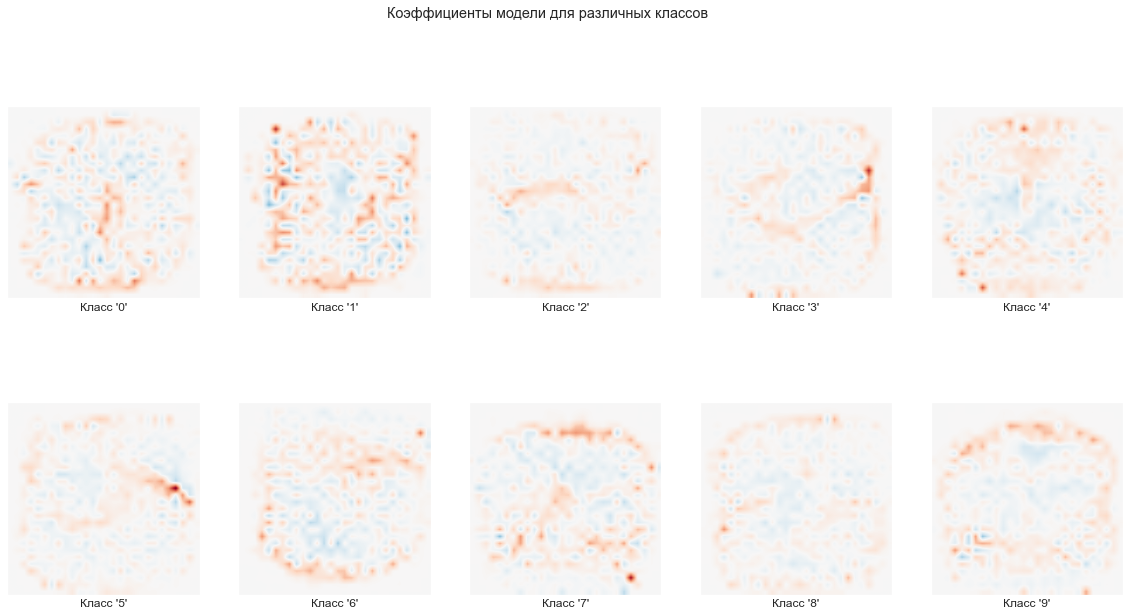

In [30]:
coef = clf_ovr.coef_.copy()
scale = np.abs(coef).max()
plt.figure(figsize=(20,10))

for i in range(10): # 0-9
    coef_plot = plt.subplot(2, 5, i + 1) # 2x5 plot

    coef_plot.imshow(coef[i].reshape(28,28), 
                     cmap=plt.cm.RdBu,
                     vmin=-scale, vmax=scale,
                    interpolation='bilinear')
    
    coef_plot.set_xticks(()); coef_plot.set_yticks(()) # remove ticks
    coef_plot.set_xlabel(f"Класс '{i}'")

plt.suptitle('Коэффициенты модели для различных классов');

#### 3.3 Метрики

In [31]:
score_test_ovr = clf_ovr.score(X_test, y_test) # accuracy на тестовой выборке
print(f'Accuracy на тестовой выборке составила {round(score_test_ovr, 3)}')

Accuracy на тестовой выборке составила 0.913


In [32]:
y_score_ovr = clf_ovr.predict_proba(X_test)
np.round(roc_auc_score(y_test, y_score_ovr, average='macro', multi_class = 'ovr'), 4)

0.9875

In [33]:
# score_test_my = sample_clf.score(X_test, y_test)
# y_score_my = sample_clf.predict_proba(X_test)

### Сравним мультиномиальный логрег и OvR:

In [34]:
res = pd.DataFrame(
{'regression_type' : ['multinomial', 'OvR'
#                       , 'multinomial_fitted'
                     ],
'accuracy' : [round(score_test, 3), round(score_test_ovr, 3)
#               ,  round(score_test_my, 3)
             ],
'macro AUC' : [np.round(roc_auc_score(y_test, y_score, average='macro', multi_class = 'ovr'), 3),
               np.round(roc_auc_score(y_test, y_score_ovr, average='macro', multi_class = 'ovr'), 3)
#                ,np.round(roc_auc_score(y_test, y_score_my, average='macro', multi_class = 'ovr'), 3)
              ]
}
)
res #мультиномиальный логрег показал себя несколько лучше, чем OvR:

,regression_type,accuracy,macro AUC
0,multinomial,0.913,0.990
1,OvR,0.913,0.988
